# Analyse par simulation — files d’attente (moulinette)

Deux cas étudiés :
- **Waterfall** (exécution des tests puis renvoi des résultats)
- **Channels & dams** (ING / PREPA + barrage périodique + politiques)

In [1]:
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data_simulator import (
    Population,
    mmck_blocking_probability,
    simulate_channels_and_dams,
    simulate_waterfall,
    write_job_records_csv,
    write_metrics_csv,
)

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 200)

In [2]:
def safe_div(a: float, b: float) -> float:
    return a / b if b else np.nan


def summarize_runs(run_rows: pd.DataFrame, group_cols: list[str]) -> pd.DataFrame:
    # Agrégation simple: taux agrégés et E[T] pondérée par completed
    g = run_rows.groupby(group_cols, dropna=False)

    def weighted_mean(x):
        w = x['completed'].to_numpy()
        v = x['mean_sojourn'].to_numpy()
        mask = np.isfinite(v) & (w > 0)
        if not mask.any():
            return np.nan
        return np.average(v[mask], weights=w[mask])

    out = g.agg(
        arrivals=('arrivals', 'sum'),
        accepted=('accepted', 'sum'),
        refused_stage1=('refused_stage1', 'sum'),
        stage2_refused=('stage2_refused', 'sum'),
        blank_pages=('blank_pages', 'sum'),
        permanent_blanks=('permanent_blanks', 'sum'),
        completed=('completed', 'sum'),
    ).reset_index()

    out['refused_stage1_rate'] = out['refused_stage1'] / out['arrivals']
    out['blank_pages_rate_given_accepted'] = out['blank_pages'] / out['accepted']
    out['permanent_blank_rate_given_accepted'] = out['permanent_blanks'] / out['accepted']
    out['mean_sojourn_weighted'] = g.apply(weighted_mean, include_groups=False).to_numpy()
    return out

In [3]:
def step_series(events: list[tuple[float, int]], t_end: float | None = None):
    # events: (t, delta) -> DataFrame(t, x) pour escalier
    events = sorted(events)
    ts = [0.0]
    xs = [0]
    x = 0
    for t, d in events:
        ts.append(t)
        xs.append(x)
        x += d
        ts.append(t)
        xs.append(x)
    if t_end is not None:
        ts.append(t_end)
        xs.append(x)
    return pd.DataFrame({'t': ts, 'x': xs})


def waterfall_series_df(jobs, horizon: float) -> pd.DataFrame:
    s1_sys = []  # (t, +1/-1)
    s1_q = []
    s2_sys = []
    s2_q = []

    for j in jobs:
        if not j.accepted:
            continue
        # stage 1 system [arrival, s1_end]
        s1_sys.append((j.arrival_t, +1))
        if j.s1_end_t is not None:
            s1_sys.append((j.s1_end_t, -1))
        # stage 1 queue [arrival, s1_start]
        if j.s1_start_t is not None:
            s1_q.append((j.arrival_t, +1))
            s1_q.append((j.s1_start_t, -1))
        # stage 2 only if not refused
        if j.stage2_refused or j.s1_end_t is None:
            continue
        # stage 2 queue [s1_end, s2_start]
        if j.s2_start_t is not None:
            s2_q.append((j.s1_end_t, +1))
            s2_q.append((j.s2_start_t, -1))
        # stage 2 system [s1_end, s2_end]
        s2_sys.append((j.s1_end_t, +1))
        if j.s2_end_t is not None:
            s2_sys.append((j.s2_end_t, -1))

    parts = []
    for name, events in [('S1_system', s1_sys), ('S1_queue', s1_q), ('S2_system', s2_sys), ('S2_queue', s2_q)]:
        df = step_series(events, t_end=horizon)
        df['series'] = name
        parts.append(df)
    return pd.concat(parts, ignore_index=True)

In [4]:
from pathlib import Path

RESULTS_DIR = Path('results')
FIG_DIR = RESULTS_DIR / 'figures'
TABLE_DIR = RESULTS_DIR / 'tables'
for _d in [RESULTS_DIR, FIG_DIR, TABLE_DIR]:
    _d.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name: str):
    fig.savefig(FIG_DIR / f"{name}.png", dpi=200, bbox_inches='tight')
    fig.savefig(FIG_DIR / f"{name}.pdf", bbox_inches='tight')

def export_table(df: pd.DataFrame, name: str, index: bool = False):
    df.to_csv(TABLE_DIR / f"{name}.csv", index=index)
    # Requires `tabulate` installed (pandas uses it for to_markdown).
    try:
        md = df.to_markdown(index=index)
        (TABLE_DIR / f"{name}.md").write_text(md, encoding='utf-8')
    except Exception as e:
        print(f"(warn) table markdown export failed for {name}: {e}")

def time_average_step(part: pd.DataFrame, horizon: float) -> float:
    # part columns: t, x; piecewise-constant with possible duplicate t at jumps
    part = part.sort_values('t')
    t = part['t'].to_numpy()
    x = part['x'].to_numpy()
    if len(t) < 2:
        return float(x[0]) if len(x) else 0.0
    dt = np.diff(t)
    return float(np.sum(x[:-1] * dt) / horizon)

def waterfall_server_metrics(jobs: list[JobRecord], horizon: float, exec_servers: int) -> dict[str, float]:
    # Utilisation par intégrale des temps de service observés
    s1_busy = 0.0
    s2_busy = 0.0
    backups_written = 0
    for j in jobs:
        if not j.accepted:
            continue
        if j.backed_up:
            backups_written += 1
        if j.s1_start_t is not None and j.s1_end_t is not None:
            s1_busy += max(0.0, min(j.s1_end_t, horizon) - max(j.s1_start_t, 0.0))
        if (not j.stage2_refused) and j.s2_start_t is not None and j.s2_end_t is not None:
            s2_busy += max(0.0, min(j.s2_end_t, horizon) - max(j.s2_start_t, 0.0))

    s1_util = s1_busy / (max(1, exec_servers) * horizon)
    s2_util = s2_busy / (1.0 * horizon)

    series = waterfall_series_df(jobs, horizon)
    avg = (
        series.groupby('series', as_index=False)
        .apply(lambda g: time_average_step(g[['t', 'x']], horizon), include_groups=False)
        .reset_index()
    )
    # pandas >=2.0: .apply returns DataFrame with column None, not 0
    if None in avg.columns:
        avg = avg.rename(columns={None: 'time_avg'})
    elif 0 in avg.columns:
        avg = avg.rename(columns={0: 'time_avg'})
    avg_map = dict(zip(avg['series'], avg['time_avg']))

    return {
        's1_util': float(s1_util),
        's2_util': float(s2_util),
        's1_system_timeavg': float(avg_map.get('S1_system', 0.0)),
        's1_queue_timeavg': float(avg_map.get('S1_queue', 0.0)),
        's2_system_timeavg': float(avg_map.get('S2_system', 0.0)),
        's2_queue_timeavg': float(avg_map.get('S2_queue', 0.0)),
        'backups_written': float(backups_written),
    }

def summarize_runs_with_means(df: pd.DataFrame, group_cols: list[str], mean_cols: list[str]) -> pd.DataFrame:
    base = summarize_runs(df, group_cols=group_cols)
    extra = (
        df.groupby(group_cols, as_index=False)[mean_cols]
        .mean(numeric_only=True)
    )
    return base.merge(extra, on=group_cols, how='left')

# 1) Waterfall

In [5]:
H = 500.0
seeds = list(range(1, 21))

K = 3
mu_s = 1.0
mu_f = 2.0

ks = 20
kf = 20

lambdas = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0])
backup_p = 0.0

In [6]:
rows = []
for lam in lambdas:
    for sd in seeds:
        m, _jobs = simulate_waterfall(
            seed=int(sd), horizon=float(H), arrival_rate=float(lam),
            exec_servers=int(K), exec_service_rate=float(mu_s),
            send_service_rate=float(mu_f),
            ks=int(ks), kf=int(kf), backup_probability=float(backup_p),
        )
        rows.append({
            'lambda': float(lam),
            'seed': int(sd),
            'K': int(K),
            'mu_s': float(mu_s),
            'mu_f': float(mu_f),
            'ks': int(ks),
            'kf': int(kf),
            'backup_p': float(backup_p),
            **m.to_dict(),
        })
wf_runs = pd.DataFrame(rows)
wf_summary = summarize_runs(wf_runs, group_cols=['lambda'])
wf_summary

,lambda,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,0.5,5031,5031,0,0,0,0,5014,0.000000,0.000000,0.000000,1.673092
1,1.0,10036,10036,0,0,0,0,10002,0.000000,0.000000,0.000000,2.033965
2,1.5,14974,14974,0,11,11,11,14882,0.000000,0.000735,0.000735,3.048877
3,2.0,20029,20029,0,851,851,851,18902,0.000000,0.042488,0.042488,6.666521
4,2.5,24903,24859,44,4699,4699,4699,19717,0.001767,0.189026,0.189026,10.473757
5,3.0,29847,28772,1075,8060,8060,8060,20035,0.036017,0.280133,0.280133,13.017214
6,4.0,40051,29945,10106,8946,8946,8946,20214,0.252328,0.298748,0.298748,15.905848


## Conclusion — Waterfall (sweep en λ)
- $E[T]$ augmente fortement quand $\lambda$ approche/s dépasse la capacité : la file se charge et la latence explose.
- Le taux de refus à l’entrée (stage 1) reste faible pour petites charges puis devient notable aux plus grandes valeurs de $\lambda$.
- Sans backup (`backup_p=0`), les pages blanches sont toutes permanentes : `permanent_blank_rate_given_accepted` suit `blank_pages_rate_given_accepted`.

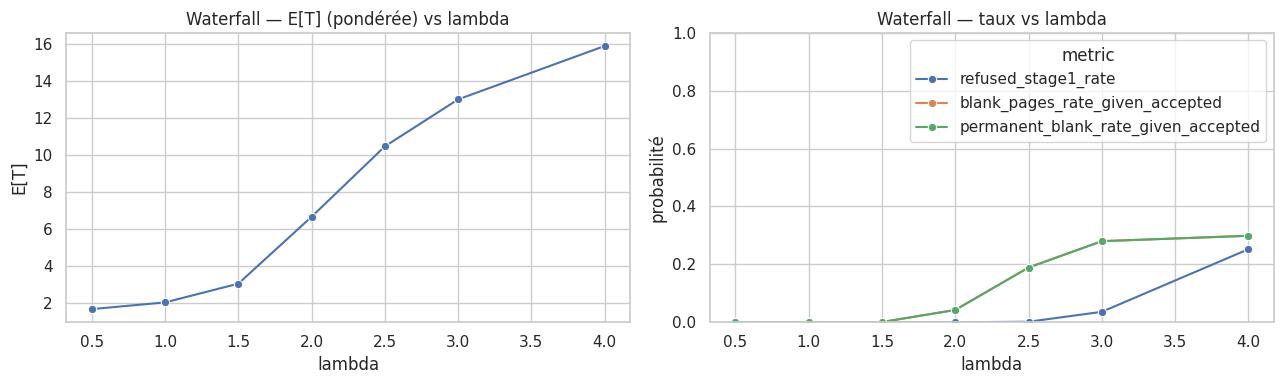

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sns.lineplot(data=wf_summary, x='lambda', y='mean_sojourn_weighted', marker='o', ax=axes[0])
axes[0].set_title('Waterfall — E[T] (pondérée) vs lambda')
axes[0].set_ylabel('E[T]')

rates = wf_summary.melt(
    id_vars=['lambda'],
    value_vars=['refused_stage1_rate', 'blank_pages_rate_given_accepted', 'permanent_blank_rate_given_accepted'],
    var_name='metric',
    value_name='rate',
)
sns.lineplot(data=rates, x='lambda', y='rate', hue='metric', marker='o', ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Waterfall — taux vs lambda')
axes[1].set_ylabel('probabilité')

plt.tight_layout()
save_fig(fig, 'waterfall_lambda_sweep')
plt.show()

## Lecture des courbes
- La transition « faible charge → congestion » est nette : au-delà d’un certain $\lambda$, la latence moyenne et les pertes augmentent rapidement.
- Les courbes de pertes (refus / pages blanches) permettent de choisir un point de fonctionnement ou de dimensionner `K`, `ks`, `kf`.

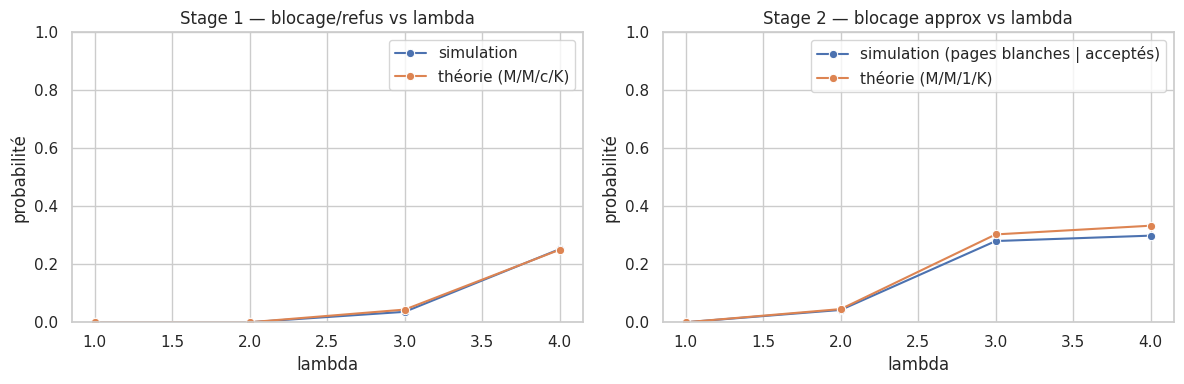

In [8]:
# Blocage théorique M/M/c/K (approx par étage)
theory = []
for lam in [1.0, 2.0, 3.0, 4.0]:
    b1 = mmck_blocking_probability(lam, mu_s, K, K + ks)
    lam_eff = lam * (1.0 - b1)
    b2 = mmck_blocking_probability(lam_eff, mu_f, 1, 1 + kf)
    theory.append({'lambda': lam, 'block_S1': b1, 'lambda_eff': lam_eff, 'block_S2': b2})

theory_df = pd.DataFrame(theory)
theory_df

# Comparaison théorie vs simulation (sur les lambdas communs)
comp = wf_summary.merge(theory_df, on='lambda', how='inner')
if comp.empty:
    print("Aucun lambda en commun entre wf_summary et theory_df.")
else:
    comp = comp.copy()
    comp['abs_err_S1'] = (comp['refused_stage1_rate'] - comp['block_S1']).abs()
    comp['abs_err_S2'] = (comp['blank_pages_rate_given_accepted'] - comp['block_S2']).abs()
    comp[['lambda', 'refused_stage1_rate', 'block_S1', 'abs_err_S1', 'blank_pages_rate_given_accepted', 'block_S2', 'abs_err_S2']]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Stage 1: refus entrée
    sns.lineplot(data=comp, x='lambda', y='refused_stage1_rate', marker='o', ax=axes[0], label='simulation')
    sns.lineplot(data=comp, x='lambda', y='block_S1', marker='o', ax=axes[0], label='théorie (M/M/c/K)')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Stage 1 — blocage/refus vs lambda')
    axes[0].set_ylabel('probabilité')
    axes[0].legend()

    # Stage 2: approximation "pages blanches parmi acceptés"
    sns.lineplot(data=comp, x='lambda', y='blank_pages_rate_given_accepted', marker='o', ax=axes[1], label='simulation (pages blanches | acceptés)')
    sns.lineplot(data=comp, x='lambda', y='block_S2', marker='o', ax=axes[1], label='théorie (M/M/1/K)')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Stage 2 — blocage approx vs lambda')
    axes[1].set_ylabel('probabilité')
    axes[1].legend()

    plt.tight_layout()
    save_fig(fig, 'waterfall_theory_vs_sim')
    export_table(comp, 'waterfall_theory_vs_sim_table', index=False)
    plt.show()

## Comparaison théorie vs simulation
- Les courbes théorie/simulation sont très proches pour le blocage au stage 1 et l’approximation au stage 2.
- L’approximation utilisée est volontairement simple (chaque étage vu comme $M/M/c/K$ avec un débit effectif pour l’étage 2) : elle sert de repère et valide l’ordre de grandeur des résultats simulés.

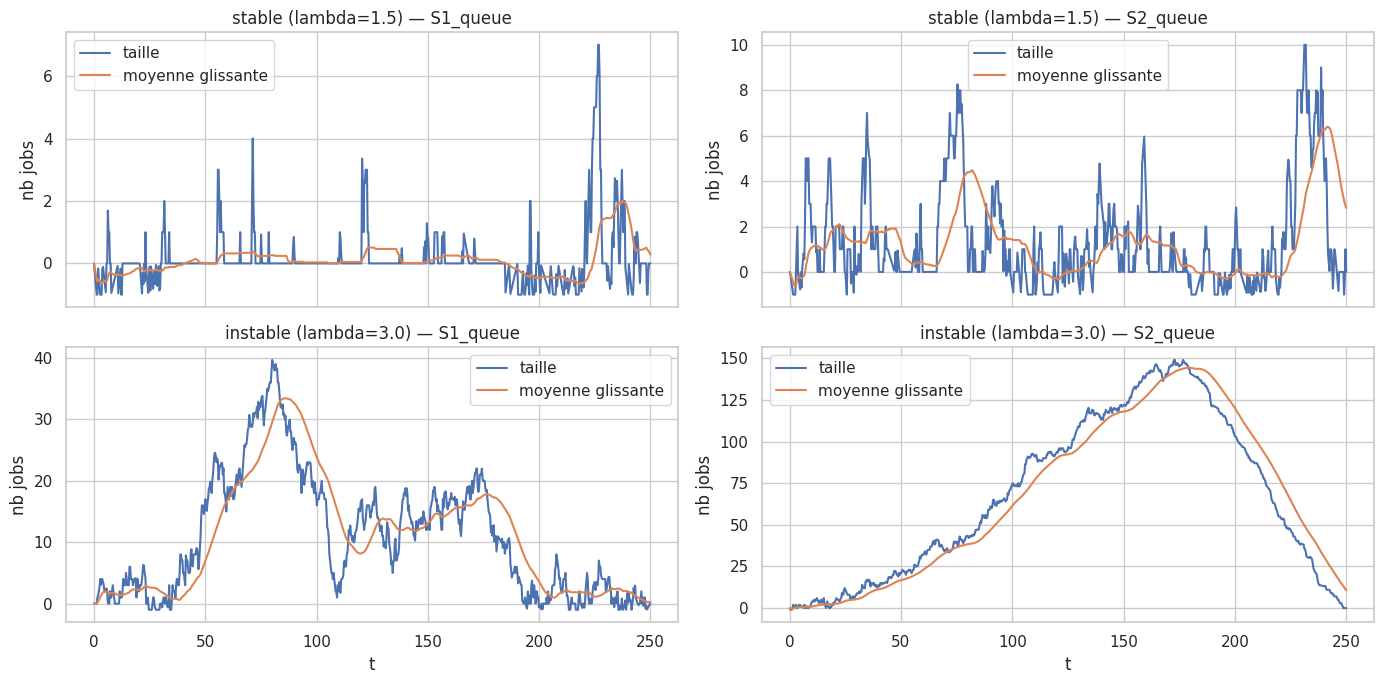

In [9]:
# Stationnarité (files infinies): comparaison stable vs instable via séries temporelles
H_ts = 250.0
K_ts = 3
mu_s_ts = 1.0
mu_f_ts = 2.0

m_st, jobs_st = simulate_waterfall(
    seed=1, horizon=H_ts, arrival_rate=1.5,
    exec_servers=K_ts, exec_service_rate=mu_s_ts,
    send_service_rate=mu_f_ts,
    ks=None, kf=None, backup_probability=0.0,
)
m_un, jobs_un = simulate_waterfall(
    seed=1, horizon=H_ts, arrival_rate=3.0,
    exec_servers=K_ts, exec_service_rate=mu_s_ts,
    send_service_rate=mu_f_ts,
    ks=None, kf=None, backup_probability=0.0,
)

df_st = waterfall_series_df(jobs_st, H_ts)
df_st['scenario'] = 'stable (lambda=1.5)'
df_un = waterfall_series_df(jobs_un, H_ts)
df_un['scenario'] = 'instable (lambda=3.0)'
df_ts = pd.concat([df_st, df_un], ignore_index=True)

# rolling mean (sur une grille régulière) pour visualiser la convergence (ou non)
grid = np.linspace(0, H_ts, 800)

def sample_on_grid(df):
    # df: columns t, x, series, scenario ; retourne df re-échantillonné par interpolation 'forward-fill'
    out = []
    for (scenario, series), part in df.groupby(['scenario', 'series']):
        part = part.sort_values('t')
        xs = np.interp(grid, part['t'].to_numpy(), part['x'].to_numpy(), left=0, right=part['x'].iloc[-1])
        o = pd.DataFrame({'t': grid, 'x': xs, 'scenario': scenario, 'series': series})
        o['x_roll'] = pd.Series(xs).rolling(window=50, min_periods=1).mean().to_numpy()
        out.append(o)
    return pd.concat(out, ignore_index=True)

df_grid = sample_on_grid(df_ts)

fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True)

for i, scenario in enumerate(['stable (lambda=1.5)', 'instable (lambda=3.0)']):
    for j, series in enumerate(['S1_queue', 'S2_queue']):
        ax = axes[i, j]
        part = df_grid[(df_grid['scenario'] == scenario) & (df_grid['series'] == series)]
        sns.lineplot(data=part, x='t', y='x', ax=ax, label='taille')
        sns.lineplot(data=part, x='t', y='x_roll', ax=ax, label='moyenne glissante')
        ax.set_title(f"{scenario} — {series}")
        ax.set_ylabel('nb jobs')
        ax.legend()

plt.tight_layout()
save_fig(fig, 'waterfall_stationarity_trajectories')
plt.show()

## Conclusion — Stationnarité (trajectoires)
- Cas stable : les tailles de file restent d’ordre constant et la moyenne glissante n’a pas de tendance marquée à diverger.
- Cas instable : les files prennent des valeurs beaucoup plus grandes et présentent des dérives (croissance soutenue sur une partie de l’horizon), ce qui traduit une charge globale trop élevée.

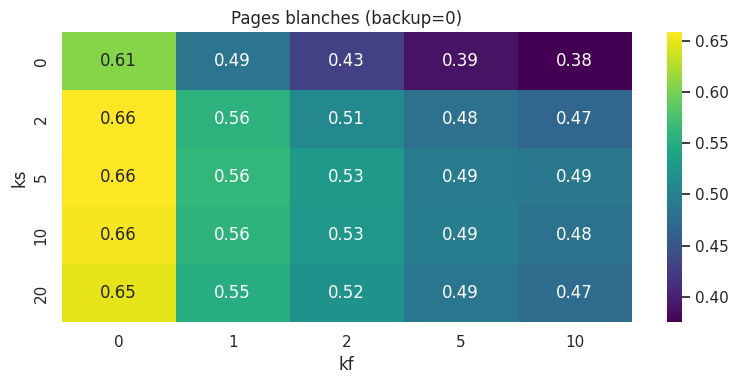

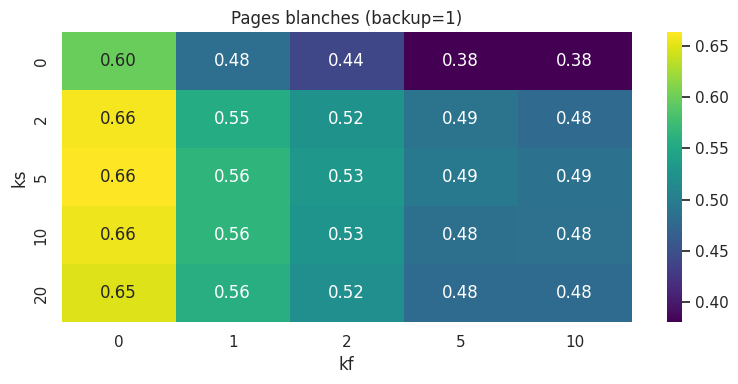

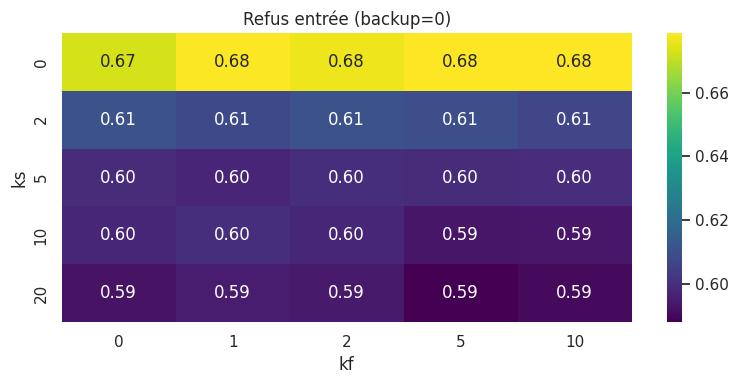

In [10]:
# Heatmap: effet (ks, kf) sur pages blanches et refus (avec/ sans backup)
H2 = 400.0
seeds2 = list(range(1, 31))
K2 = 2
mu_s2 = 1.0
mu_f2 = 1.0
lam2 = 5.0

ks_list = [0, 2, 5, 10, 20]
kf_list = [0, 1, 2, 5, 10]

def run_grid(backup_p):
    rows = []
    for ks_ in ks_list:
        for kf_ in kf_list:
            for sd in seeds2:
                m, _ = simulate_waterfall(
                    seed=int(sd), horizon=float(H2), arrival_rate=float(lam2),
                    exec_servers=int(K2), exec_service_rate=float(mu_s2),
                    send_service_rate=float(mu_f2),
                    ks=int(ks_), kf=int(kf_), backup_probability=float(backup_p),
)
                rows.append({
                    'ks': ks_, 'kf': kf_, 'backup_p': backup_p,
                    **m.to_dict(),
                })
    df = pd.DataFrame(rows)
    s = summarize_runs(df, group_cols=['ks', 'kf', 'backup_p'])
    return s

s0 = run_grid(0.0)
s1 = run_grid(1.0)

def heatmap(df, value_col, title, fname):
    pivot = df.pivot(index='ks', columns='kf', values=value_col).sort_index()
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('kf')
    ax.set_ylabel('ks')
    plt.tight_layout()
    save_fig(fig, fname)
    plt.show()

heatmap(s0, 'blank_pages_rate_given_accepted', 'Pages blanches (backup=0)', 'waterfall_heatmap_blank_backup0')
heatmap(s1, 'blank_pages_rate_given_accepted', 'Pages blanches (backup=1)', 'waterfall_heatmap_blank_backup1')
heatmap(s0, 'refused_stage1_rate', 'Refus entrée (backup=0)', 'waterfall_heatmap_refus_backup0')

## Conclusion — Effet des capacités (`ks`, `kf`)
- À charge très élevée (ici `lam2=5.0`), augmenter `kf` réduit nettement les pages blanches : on absorbe mieux la congestion de l’étape 2.
- Augmenter `ks` réduit surtout le refus à l’entrée (étape 1) : davantage de buffer avant l’exécution diminue le blocage au stage 1.
- Quand `backup_p` passe de 0 à 1, le taux de pages blanches reste similaire (on refuse toujours au stage 2), mais elles ne sont plus « permanentes » : le résultat peut être récupéré plus tard.

## Benchmarks multi-paramètres — Waterfall
On évalue l’impact de λ (arrivée), K (serveurs), μ_s (service), μ_f (sortie), backup, ks/kf sur toutes les métriques clés :
- Temps de séjour moyen
- Taux de refus à l’entrée
- Taux de pages blanches et pages blanches permanentes
- Nombre moyen de jobs en file/système
- Coût total et coût par arrivée

In [11]:
# Sweep multi-paramètres Waterfall : λ, K, μ_s, μ_f, backup, ks/kf
H_mp = 350.0
seeds_mp = list(range(1, 10))
lambdas_mp = [2.0, 4.0, 6.0]
Ks_mp = [1, 2, 4]
mu_s_mp = [0.5, 1.0, 2.0]
mu_f_mp = [0.5, 1.0, 2.0]
ks_mp = [0, 5]
kf_mp = [0, 2]
backup_strats_mp = [('none', 0.0), ('random', 0.5), ('systematic', 1.0)]

rows = []
for lam in lambdas_mp:
    for K in Ks_mp:
        for mu_s in mu_s_mp:
            for mu_f in mu_f_mp:
                for ks_ in ks_mp:
                    for kf_ in kf_mp:
                        for strat, bp in backup_strats_mp:
                            for sd in seeds_mp:
                                m, jobs = simulate_waterfall(
                                    seed=int(sd), horizon=float(H_mp), arrival_rate=float(lam),
                                    exec_servers=int(K), exec_service_rate=float(mu_s),
                                    send_service_rate=float(mu_f),
                                    ks=int(ks_), kf=int(kf_),
                                    backup_probability=float(bp), backup_strategy=strat,
                                )
                                srv = waterfall_server_metrics(jobs, horizon=H_mp, exec_servers=K)

                                # coût fictif
                                c_server_per_time = 1.0
                                c_backup_per_job = 0.3
                                c_refused = 2.0
                                c_blank = 1.0
                                c_perm_blank_extra = 4.0
                                server_cost = c_server_per_time * (K + 1) * H_mp
                                backup_cost = c_backup_per_job * srv['backups_written']
                                penalty = (
                                    c_refused * m.refused_stage1
                                    + c_blank * m.blank_pages
                                    + c_perm_blank_extra * m.permanent_blanks
                                )
                                total_cost = server_cost + backup_cost + penalty
                                cost_per_arrival = total_cost / max(1, m.arrivals)

                                rows.append({
                                    'seed': sd, 'lambda': lam, 'K': K, 'mu_s': mu_s, 'mu_f': mu_f,
                                    'ks': ks_, 'kf': kf_, 'backup_strategy': strat, 'backup_p': bp,
                                    **m.to_dict(), **srv,
                                    'server_cost': server_cost,
                                    'backup_cost': backup_cost,
                                    'penalty_cost': penalty,
                                    'total_cost': total_cost,
                                    'cost_per_arrival': cost_per_arrival,
                                })

mp_runs = pd.DataFrame(rows)
mean_cols = ['s1_util', 's2_util', 's1_system_timeavg', 's1_queue_timeavg', 's2_system_timeavg', 's2_queue_timeavg', 'backups_written', 'cost_per_arrival']
mp_summary = summarize_runs_with_means(mp_runs, group_cols=['lambda', 'K', 'mu_s', 'mu_f', 'ks', 'kf', 'backup_strategy', 'backup_p'], mean_cols=mean_cols)

export_table(mp_summary, 'waterfall_multi_param_summary', index=False)
mp_summary.head(10)

,lambda,K,mu_s,mu_f,ks,kf,backup_strategy,backup_p,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted,s1_util,s2_util,s1_system_timeavg,s1_queue_timeavg,s2_system_timeavg,s2_queue_timeavg,backups_written,cost_per_arrival
0,2.0,1,0.5,0.5,0,0,none,0.0,6264,1240,5024,467,467,467,764,0.802043,0.376613,0.376613,4.567801,0.791409,0.472550,0.681719,-0.133031,0.494356,-0.236801,0.000000,2.984691
1,2.0,1,0.5,0.5,0,0,random,0.5,6240,1262,4978,506,506,241,740,0.797756,0.400951,0.190967,4.613168,0.786080,0.469413,0.705700,-0.152708,0.492967,-0.197037,71.444444,2.872901
2,2.0,1,0.5,0.5,0,0,systematic,1.0,6264,1240,5024,467,467,0,764,0.802043,0.376613,0.000000,4.567801,0.791409,0.472550,0.681719,-0.133031,0.494356,-0.236801,137.333333,2.745178
3,2.0,1,0.5,0.5,0,2,none,0.0,6278,1230,5048,142,142,142,1072,0.804078,0.115447,0.115447,5.596330,0.804588,0.644980,0.702971,-0.154248,1.155793,0.416877,0.000000,2.725378
4,2.0,1,0.5,0.5,0,2,random,0.5,6266,1249,5017,162,162,75,1070,0.800670,0.129704,0.060048,5.710674,0.794780,0.671400,0.687106,-0.124838,1.222085,0.477773,73.111111,2.712529
5,2.0,1,0.5,0.5,0,2,systematic,1.0,6278,1230,5048,142,142,0,1072,0.804078,0.115447,0.000000,5.596330,0.804588,0.644980,0.702971,-0.154248,1.155793,0.416877,136.000000,2.693462
6,2.0,1,0.5,0.5,5,0,none,0.0,6351,1570,4781,741,741,741,772,0.752795,0.471975,0.471975,14.527502,0.990919,0.496324,5.483254,4.404771,0.491383,-0.206578,0.000000,3.082342
7,2.0,1,0.5,0.5,5,0,random,0.5,6315,1607,4708,779,779,385,771,0.745527,0.484754,0.239577,14.330671,0.992127,0.491517,5.476971,4.394624,0.511991,-0.258690,86.666667,2.893911
8,2.0,1,0.5,0.5,5,0,systematic,1.0,6351,1570,4781,741,741,0,772,0.752795,0.471975,0.000000,14.527502,0.990919,0.496324,5.483254,4.404771,0.491383,-0.206578,168.555556,2.686819
9,2.0,1,0.5,0.5,5,2,none,0.0,6322,1647,4675,435,435,435,1149,0.739481,0.264117,0.264117,16.175823,0.993311,0.762498,5.429280,4.370207,1.571916,0.727239,0.000000,2.821397


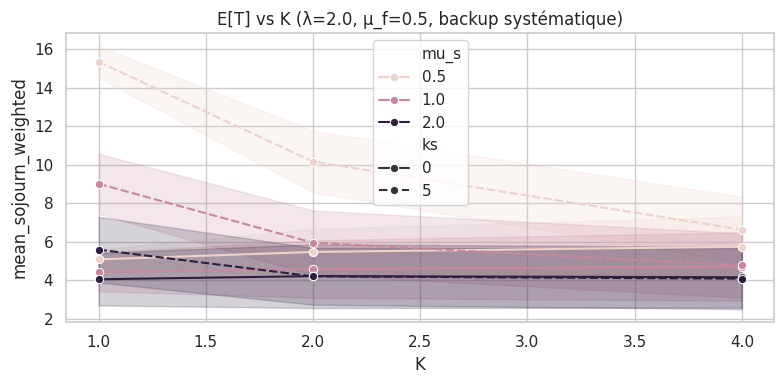

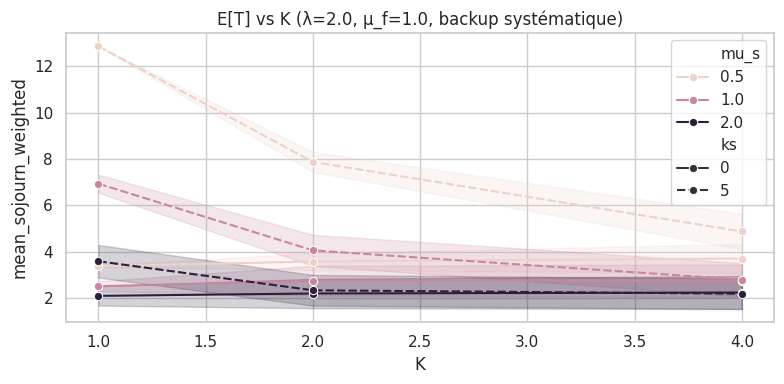

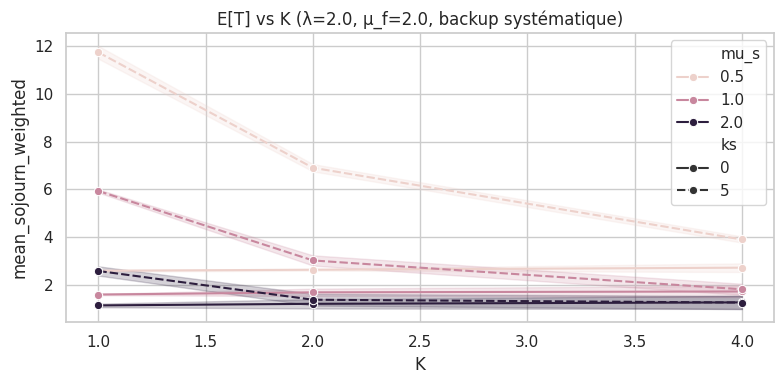

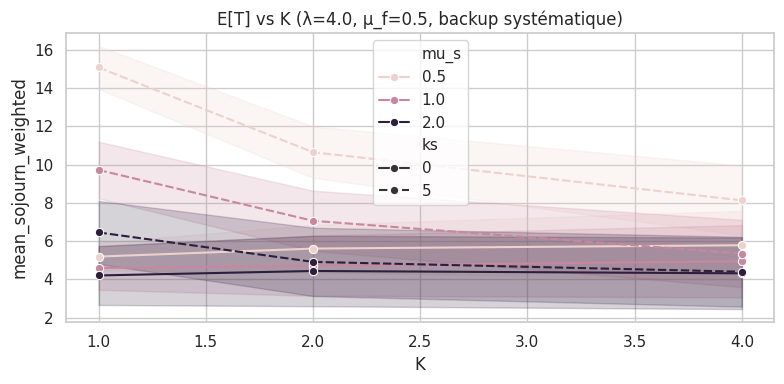

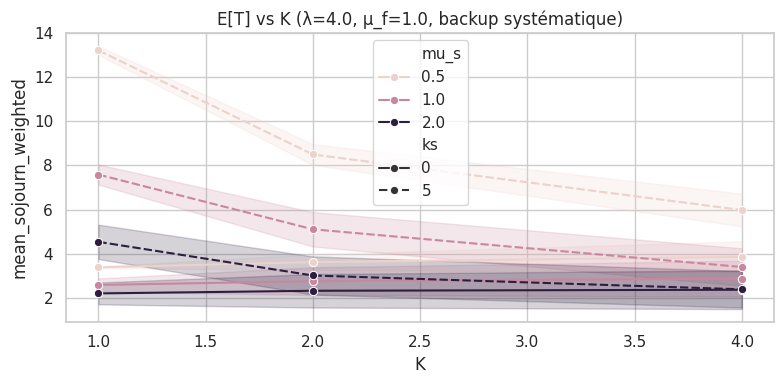

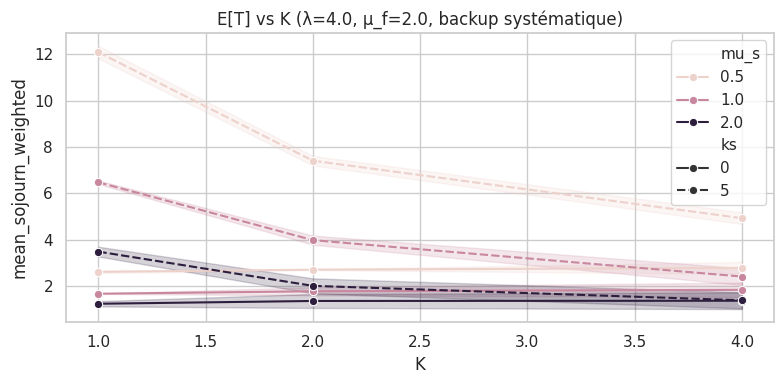

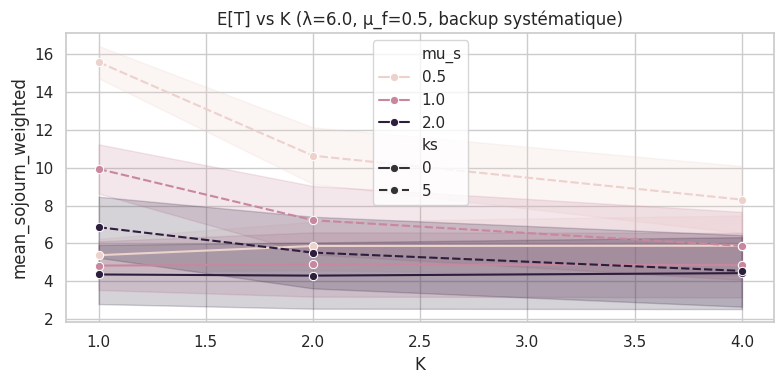

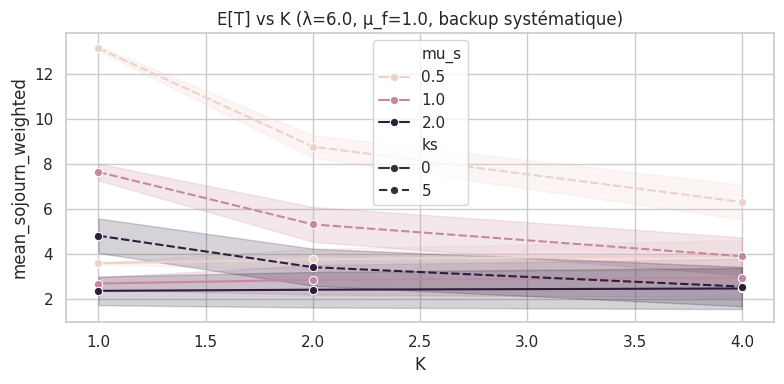

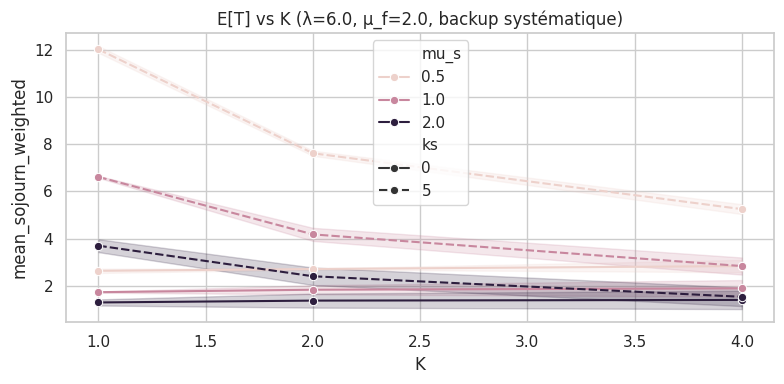

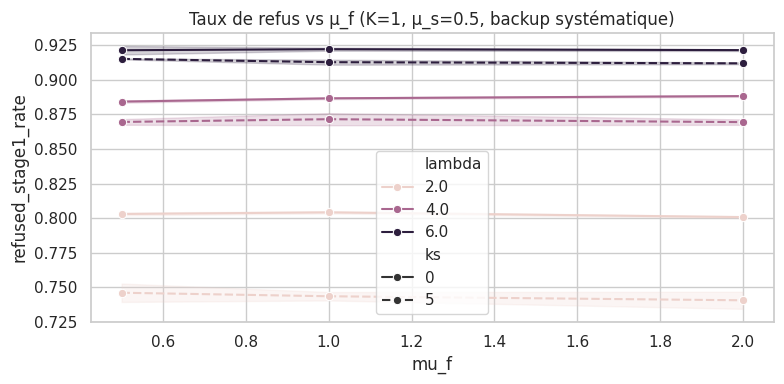

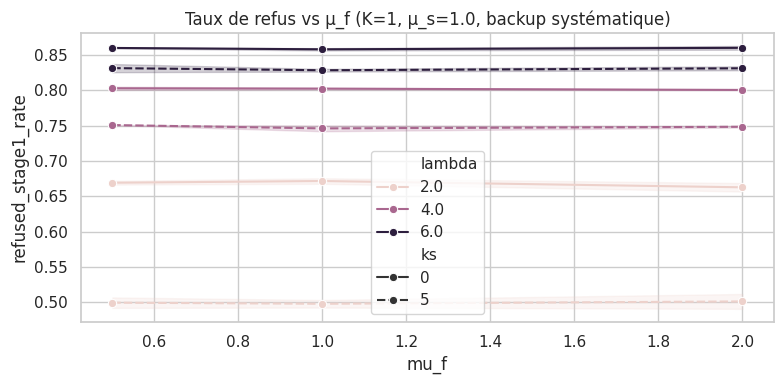

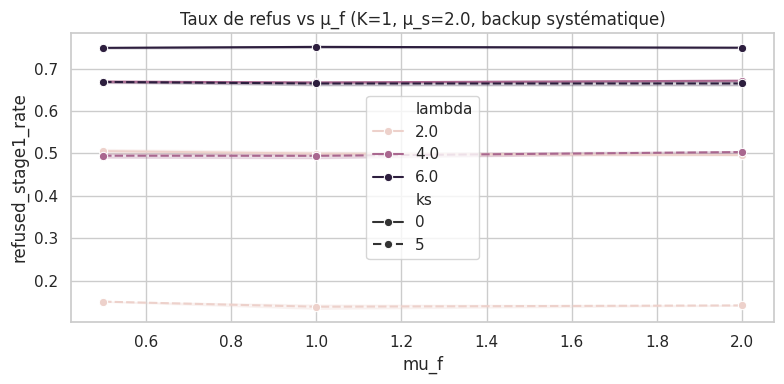

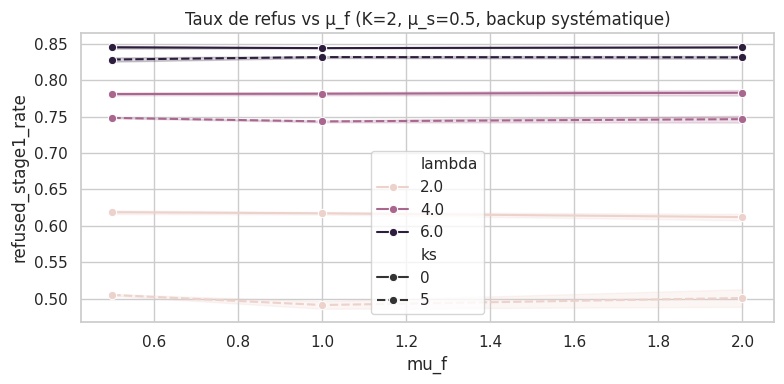

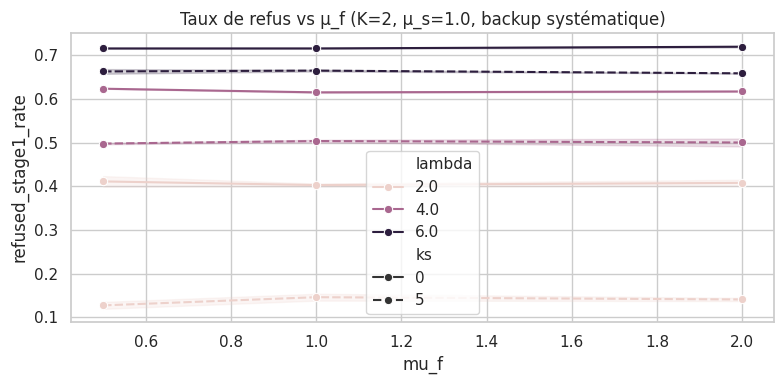

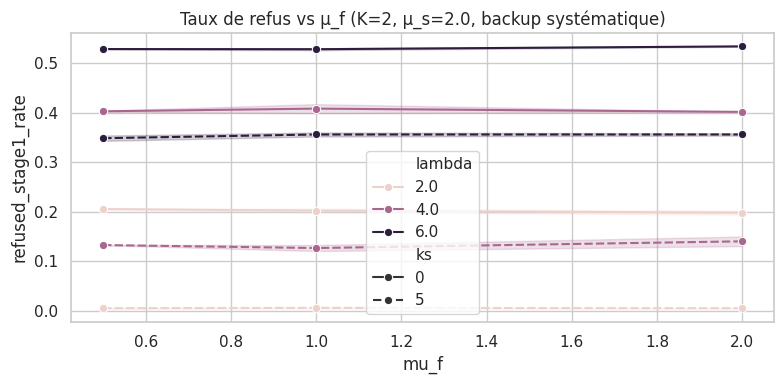

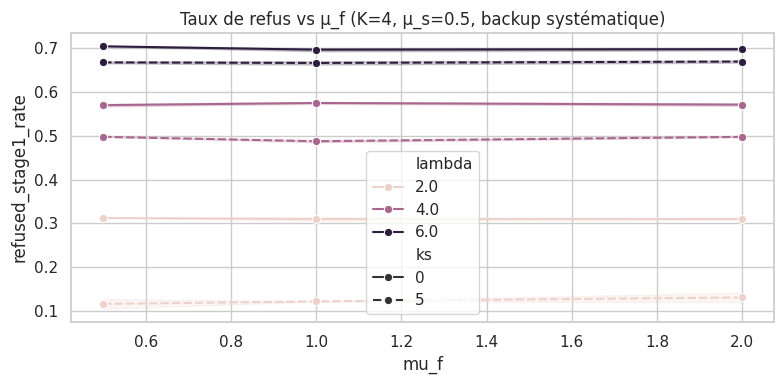

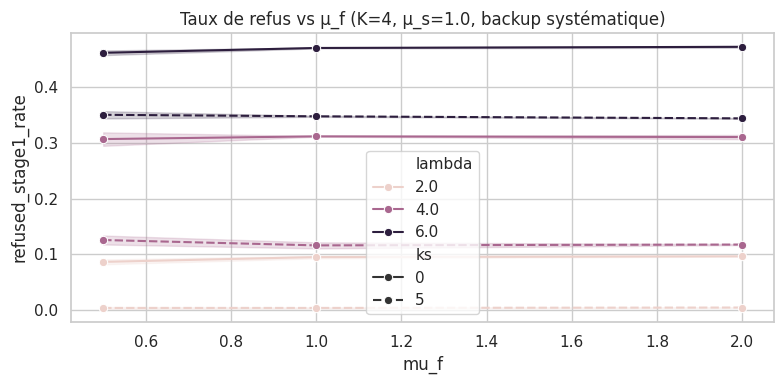

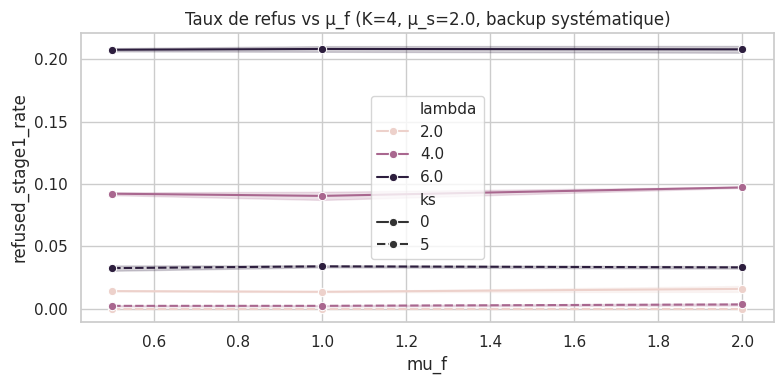

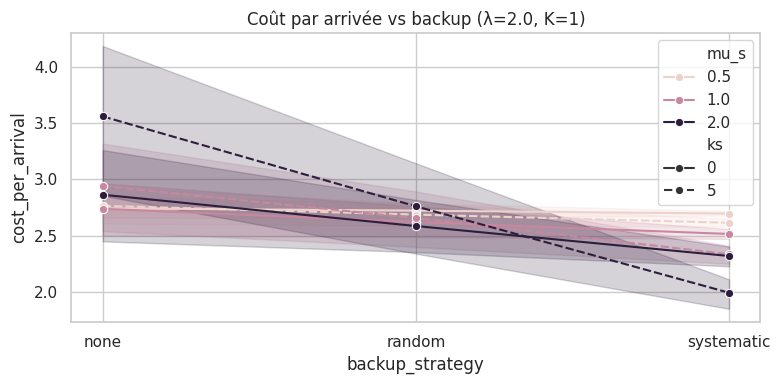

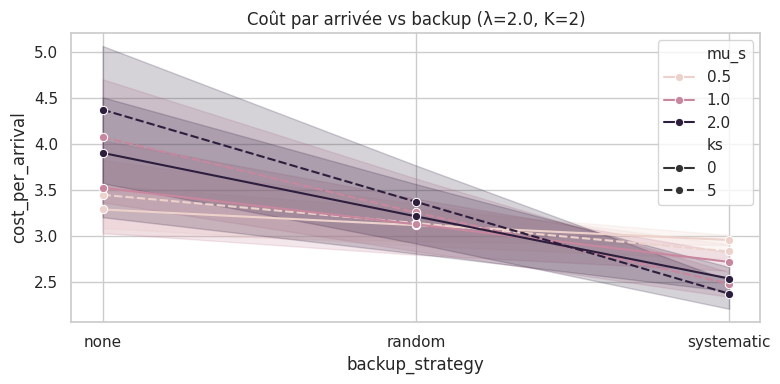

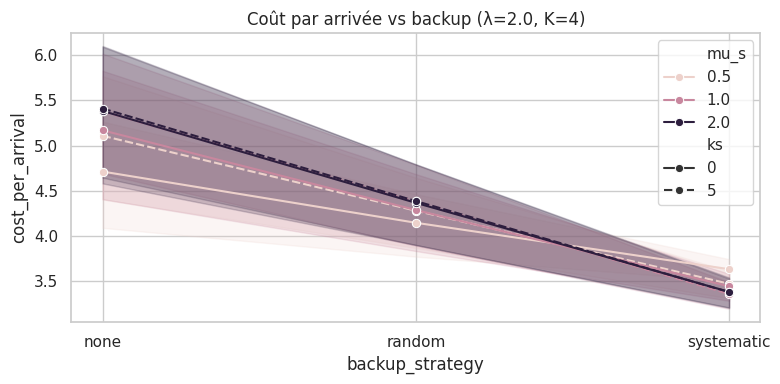

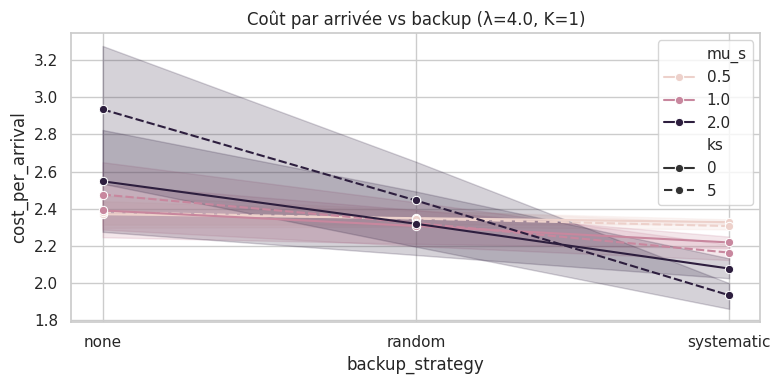

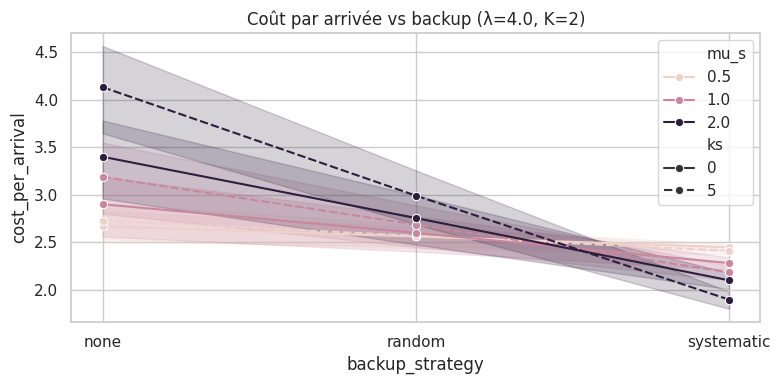

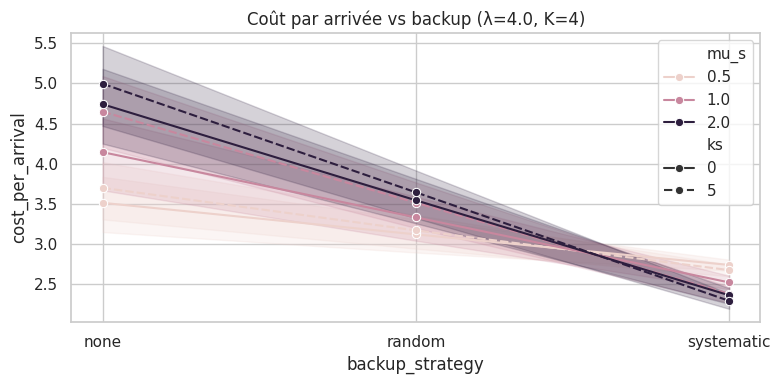

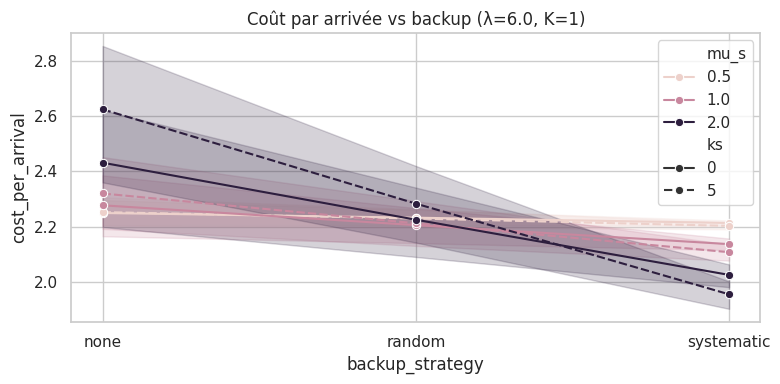

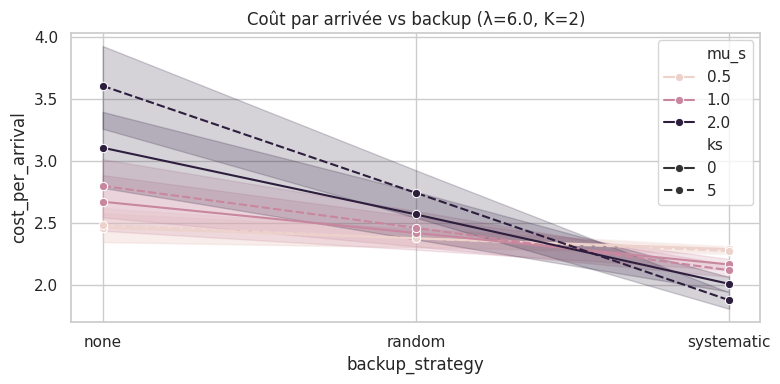

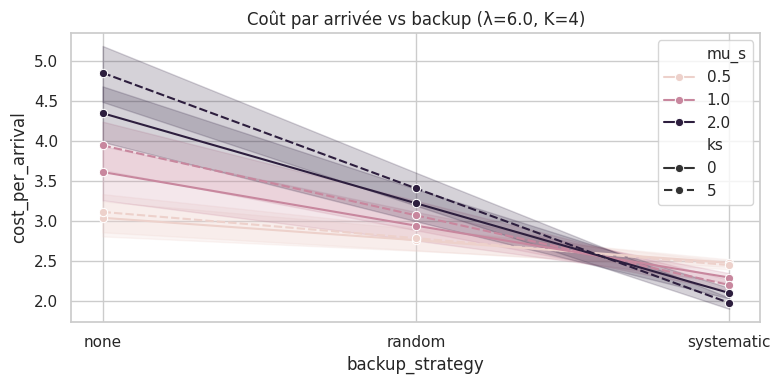

In [12]:
# Visualisation : impact des paramètres sur les métriques clés
import itertools
def plot_param_impact(df, param, metric, hue=None, style=None, title=None, fname=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(data=df, x=param, y=metric, hue=hue, style=style, marker='o', ax=ax)
    ax.set_title(title or f'{metric} vs {param}')
    ax.set_ylabel(metric)
    plt.tight_layout()
    if fname:
        save_fig(fig, fname)
    plt.show()

# Exemple : impact du nombre de serveurs et de μ_s sur le temps de séjour moyen
for lam in lambdas_mp:
    for mu_f in mu_f_mp:
        sub = mp_summary[(mp_summary['lambda'] == lam) & (mp_summary['mu_f'] == mu_f) & (mp_summary['backup_strategy'] == 'systematic')]
        plot_param_impact(sub, param='K', metric='mean_sojourn_weighted', hue='mu_s', style='ks',
                        title=f'E[T] vs K (λ={lam}, μ_f={mu_f}, backup systématique)',
                        fname=f'waterfall_E[T]_K_mu_s_lam{lam}_mu_f{mu_f}_backup_sys')

# Impact de μ_f sur le taux de refus à l’entrée
for K in Ks_mp:
    for mu_s in mu_s_mp:
        sub = mp_summary[(mp_summary['K'] == K) & (mp_summary['mu_s'] == mu_s) & (mp_summary['backup_strategy'] == 'systematic')]
        plot_param_impact(sub, param='mu_f', metric='refused_stage1_rate', hue='lambda', style='ks',
                        title=f'Taux de refus vs μ_f (K={K}, μ_s={mu_s}, backup systématique)',
                        fname=f'waterfall_refus_mu_f_K{K}_mu_s{mu_s}_backup_sys')

# Impact du backup sur le coût par arrivée
for lam in lambdas_mp:
    for K in Ks_mp:
        sub = mp_summary[(mp_summary['lambda'] == lam) & (mp_summary['K'] == K)]
        plot_param_impact(sub, param='backup_strategy', metric='cost_per_arrival', hue='mu_s', style='ks',
                        title=f'Coût par arrivée vs backup (λ={lam}, K={K})',
                        fname=f'waterfall_cost_backup_lam{lam}_K{K}')

### Conclusions sur l'impact des paramètres (Waterfall)

- **Nombre de serveurs (K)** : Augmenter K réduit le temps de séjour moyen et le taux de refus, mais le coût par arrivée peut croître si les serveurs sont chers.
- **μ_s (vitesse serveurs principaux)** : Plus μ_s est élevé, plus le système traite vite, ce qui réduit le temps de séjour et le coût, mais l'effet dépend de la saturation.
- **μ_f (vitesse backup)** : Un backup rapide (μ_f élevé) diminue le taux de refus et le coût, surtout si la stratégie de backup est efficace.
- **λ (taux d'arrivée)** : Un λ élevé augmente la congestion, le temps de séjour et le taux de refus, surtout si K ou μ_s sont faibles.
- **Backup (systématique vs aléatoire)** : Le backup systématique améliore la robustesse et réduit les refus, mais peut augmenter le coût si les backups sont chers.
- **ks/kf (coût serveurs/backup)** : Un backup peu coûteux (kf << ks) rend la stratégie systématique plus avantageuse.

**Synthèse** :
- Pour minimiser le coût et les refus, il faut ajuster K, μ_s, μ_f et la stratégie de backup selon le contexte (charge λ, coût ks/kf).
- Les visualisations ci-dessus permettent d’identifier les zones optimales selon chaque critère (client, opérateur, coût, refus, temps de séjour, jobs traités).

## Benchmark multi-critères (backup + coûts)
On ajoute une vue « opérateur » : utilisation des serveurs, nb de backups écrits, et un coût fictif combinant (capacité serveurs + backups + pénalités client).

In [13]:
# Grid coût/backup : comparaison "backup systématique" vs "backup aléatoire"
H_cost = 350.0
seeds_cost = list(range(1, 16))
lam_cost = 5.0
K_cost = 2
mu_s_cost = 1.0
mu_f_cost = 1.0

ks_cost_list = [0, 5, 20]
kf_cost_list = [0, 2, 5]

# On compare:
# - random: backup avec probabilité p
# - systematic: backup de tous les jobs acceptés après le stage 1
strategies = [
    ('none', 0.0),
    ('random', 0.5),
    ('systematic', 1.0),
 ]

# Coûts fictifs (à ajuster si besoin)
c_server_per_time = 1.0        # coût par serveur et par unité de temps
c_backup_per_job = 0.3         # coût d'écriture d'un backup
c_refused = 2.0                # pénalité par job refusé à l'entrée
c_blank = 1.0                  # pénalité par page blanche
c_perm_blank_extra = 4.0       # pénalité additionnelle si page blanche permanente

rows = []
for ks_ in ks_cost_list:
    for kf_ in kf_cost_list:
        for strat, bp in strategies:
            for sd in seeds_cost:
                m, jobs = simulate_waterfall(
                    seed=int(sd), horizon=float(H_cost), arrival_rate=float(lam_cost),
                    exec_servers=int(K_cost), exec_service_rate=float(mu_s_cost),
                    send_service_rate=float(mu_f_cost),
                    ks=int(ks_), kf=int(kf_),
                    backup_probability=float(bp), backup_strategy=strat,
                )
                srv = waterfall_server_metrics(jobs, horizon=H_cost, exec_servers=K_cost)

                # coût total sur l'horizon, puis ramené par arrivée
                server_cost = c_server_per_time * (K_cost + 1) * H_cost
                backup_cost = c_backup_per_job * srv['backups_written']
                penalty = (
                    c_refused * m.refused_stage1
                    + c_blank * m.blank_pages
                    + c_perm_blank_extra * m.permanent_blanks
                )
                total_cost = server_cost + backup_cost + penalty
                cost_per_arrival = total_cost / max(1, m.arrivals)

                rows.append({
                    'seed': sd,
                    'lambda': lam_cost,
                    'K': K_cost,
                    'ks': ks_, 'kf': kf_,
                    'backup_strategy': strat,
                    'backup_p': bp,
                    **m.to_dict(),
                    **srv,
                    'server_cost': server_cost,
                    'backup_cost': backup_cost,
                    'penalty_cost': penalty,
                    'total_cost': total_cost,
                    'cost_per_arrival': cost_per_arrival,
                })

cost_runs = pd.DataFrame(rows)
mean_cols = ['s1_util', 's2_util', 's1_system_timeavg', 's1_queue_timeavg', 's2_system_timeavg', 's2_queue_timeavg', 'backups_written', 'cost_per_arrival']
cost_summary = summarize_runs_with_means(cost_runs, group_cols=['ks', 'kf', 'backup_strategy', 'backup_p'], mean_cols=mean_cols)

cost_summary.sort_values(['ks', 'kf', 'backup_strategy']).head(12)

,ks,kf,backup_strategy,backup_p,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted,s1_util,s2_util,s1_system_timeavg,s1_queue_timeavg,s2_system_timeavg,s2_queue_timeavg,backups_written,cost_per_arrival
0,0,0,none,0.0,26201,8635,17566,5231,5231,5231,3372,0.670432,0.605790,0.605790,2.173497,0.806482,0.650136,1.425401,-0.138274,0.569173,-0.127255,0.000000,2.940165
1,0,0,random,0.5,26204,8679,17525,5256,5256,2614,3389,0.668791,0.605600,0.301187,2.170738,0.804274,0.653788,1.426721,-0.142545,0.569832,-0.121416,286.666667,2.587544
2,0,0,systematic,1.0,26201,8635,17566,5231,5231,0,3372,0.670432,0.605790,0.000000,2.173497,0.806482,0.650136,1.425401,-0.138274,0.569173,-0.127255,574.266667,2.240341
3,0,2,none,0.0,26190,8537,17653,3677,3677,3677,4811,0.674036,0.430713,0.430713,3.487681,0.805283,0.913873,1.440359,-0.151768,2.015650,1.078018,0.000000,2.651399
4,0,2,random,0.5,26273,8587,17686,3762,3762,1895,4770,0.673163,0.438104,0.220682,3.531463,0.808285,0.916554,1.416084,-0.155857,2.048027,1.100763,283.800000,2.426169
5,0,2,systematic,1.0,26190,8537,17653,3677,3677,0,4811,0.674036,0.430713,0.000000,3.487681,0.805283,0.913873,1.440359,-0.151768,2.015650,1.078018,567.266667,2.187393
6,0,5,none,0.0,26258,8481,17777,3186,3186,3186,5199,0.677013,0.375663,0.375663,5.801267,0.813054,0.978831,1.427588,-0.143453,4.565058,3.537299,0.000000,2.560679
7,0,5,random,0.5,26257,8471,17786,3222,3222,1569,5156,0.677381,0.380357,0.185220,5.924300,0.806144,0.978092,1.432828,-0.151212,4.625829,3.614962,284.266667,2.365102
8,0,5,systematic,1.0,26258,8481,17777,3186,3186,0,5199,0.677013,0.375663,0.000000,5.801267,0.813054,0.978831,1.427588,-0.143453,4.565058,3.537299,563.733333,2.171912
9,5,0,none,0.0,26229,10569,15660,6977,6977,6977,3493,0.597049,0.660138,0.660138,4.450057,0.994988,0.665362,6.150855,4.130582,0.587500,-0.119167,0.000000,3.125293


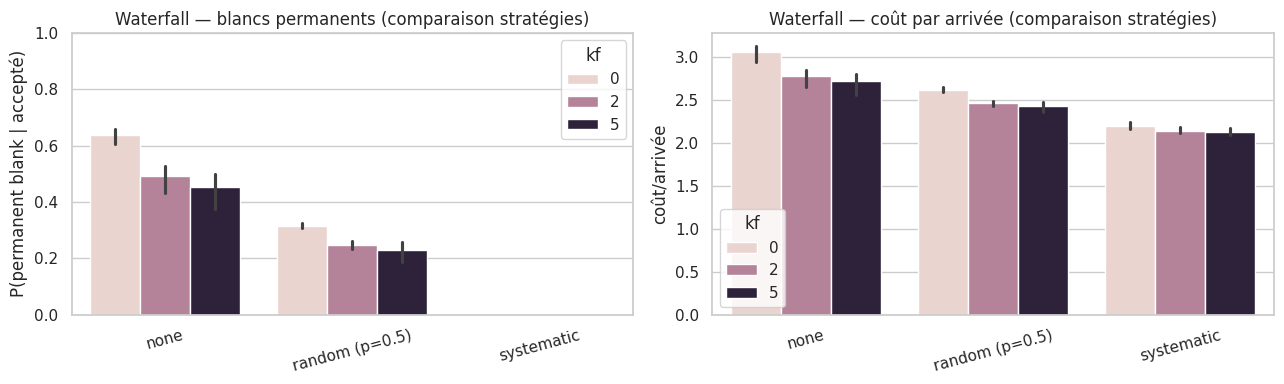

In [14]:
# Lecture du compromis: coût vs "blancs permanents" + export tables/figures
export_table(cost_summary, 'waterfall_cost_summary', index=False)

plot = cost_summary.copy()
plot['perm_blank_rate'] = plot['permanent_blank_rate_given_accepted'].fillna(0.0)
plot['strategy_label'] = plot.apply(
    lambda r: f"{r['backup_strategy']} (p={r['backup_p']})" if r['backup_strategy']=='random' else str(r['backup_strategy']),
    axis=1,
 )

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.barplot(data=plot, x='strategy_label', y='perm_blank_rate', hue='kf', ax=ax[0])
ax[0].set_title('Waterfall — blancs permanents (comparaison stratégies)')
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('')
ax[0].set_ylabel('P(permanent blank | accepté)')
ax[0].tick_params(axis='x', rotation=15)

sns.barplot(data=plot, x='strategy_label', y='cost_per_arrival', hue='kf', ax=ax[1])
ax[1].set_title('Waterfall — coût par arrivée (comparaison stratégies)')
ax[1].set_xlabel('')
ax[1].set_ylabel('coût/arrivée')
ax[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
save_fig(fig, 'waterfall_cost_tradeoff_strategies')
plt.show()

## Conclusion — Impact des stratégies de backup sur le coût et la qualité
- La stratégie systématique (backup tout) élimine les pages blanches permanentes mais augmente le coût opérateur (plus de backups écrits).
- La stratégie aléatoire permet de moduler le compromis coût/qualité : plus la probabilité de backup est élevée, moins il y a de pages blanches permanentes, mais le coût augmente.
- Pour un opérateur, il faut choisir le niveau de backup en fonction du coût acceptable et du niveau de service attendu par le client.
- Les résultats montrent que le coût marginal d’un backup supplémentaire est faible comparé à la pénalité d’une page blanche permanente, mais le backup systématique n’est optimal que si la pénalité client est très forte.

In [15]:
# Export (optionnel) : métriques agrégées et un exemple de trajectoire jobs
wf_runs.to_csv(RESULTS_DIR / 'waterfall_runs.csv', index=False)
wf_summary.to_csv(RESULTS_DIR / 'waterfall_summary.csv', index=False)
export_table(wf_summary, 'waterfall_summary', index=False)

m_ex, jobs_ex = simulate_waterfall(
    seed=42, horizon=H2, arrival_rate=lam2,
    exec_servers=K2, exec_service_rate=mu_s2,
    send_service_rate=mu_f2,
    ks=5, kf=2, backup_probability=0.3,
)
write_job_records_csv(RESULTS_DIR / 'waterfall_jobs_seed42.csv', jobs_ex)
write_metrics_csv(RESULTS_DIR / 'waterfall_metrics_seed42.csv', [m_ex])
RESULTS_DIR

PosixPath('results')

# 2) Channels & dams

In [16]:
H3 = 800.0
seeds3 = list(range(1, 21))

p_ing = Population(name='ING', arrival_rate=3.0, exec_service_rate=1.5)
p_prepa = Population(name='PREPA', arrival_rate=0.6, exec_service_rate=0.5)
pops = [p_ing, p_prepa]

K3 = 3
mu_f3 = 2.0
ks3 = 30
kf3 = 30

In [17]:
def run_cd_once(seed: int, policy: str, dam_tb: float | None, split: dict[str, int] | None):
    metrics_by_pop, _jobs = simulate_channels_and_dams(
        seed=int(seed), horizon=float(H3),
        exec_servers=int(K3), send_service_rate=float(mu_f3),
        ks=int(ks3), kf=int(kf3),
        populations=pops,
        dam_tb=dam_tb, dam_population='ING',
        policy=policy, split_servers_for=split,
    )
    rows = []
    for pop_name, m in metrics_by_pop.items():
        rows.append({
            'seed': int(seed),
            'policy': policy,
            'dam_tb': dam_tb if dam_tb is not None else np.nan,
            'population': pop_name,
            **m.to_dict(),
        })
    return rows

policies = [
    ('fifo', None, None),
    ('fifo', 20.0, None),
    ('priority_ing', None, None),
    ('split_servers', None, {'ING': 2, 'PREPA': 1}),
]

rows = []
for sd in seeds3:
    for policy, dam_tb, split in policies:
        rows += run_cd_once(sd, policy, dam_tb, split)

cd_runs = pd.DataFrame(rows)
cd_summary = summarize_runs(cd_runs, group_cols=['policy', 'dam_tb', 'population'])
cd_summary

,policy,dam_tb,population,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,fifo,20.0,ING,47920,15669,8,28,28,28,15636,0.000167,0.001787,0.001787,6.677923
1,fifo,20.0,PREPA,9535,9532,3,8,8,8,9483,0.000315,0.000839,0.000839,6.658401
2,fifo,NaN,ING,47880,44594,3286,17887,17887,17887,25904,0.068630,0.401108,0.401108,20.609141
3,fifo,NaN,PREPA,9671,8971,700,2782,2782,2782,5986,0.072381,0.310110,0.310110,21.638535
4,priority_ing,NaN,ING,48108,45165,2943,18471,18471,18471,26109,0.061175,0.408967,0.408967,16.249348
5,priority_ing,NaN,PREPA,9779,9181,598,3068,3068,3068,5600,0.061151,0.334168,0.334168,47.089753
6,split_servers,NaN,ING,47930,41534,6396,14079,14079,14079,26872,0.133445,0.338975,0.338975,16.285110
7,split_servers,NaN,PREPA,9688,8387,1301,2610,2610,2610,5207,0.134290,0.311196,0.311196,53.494720


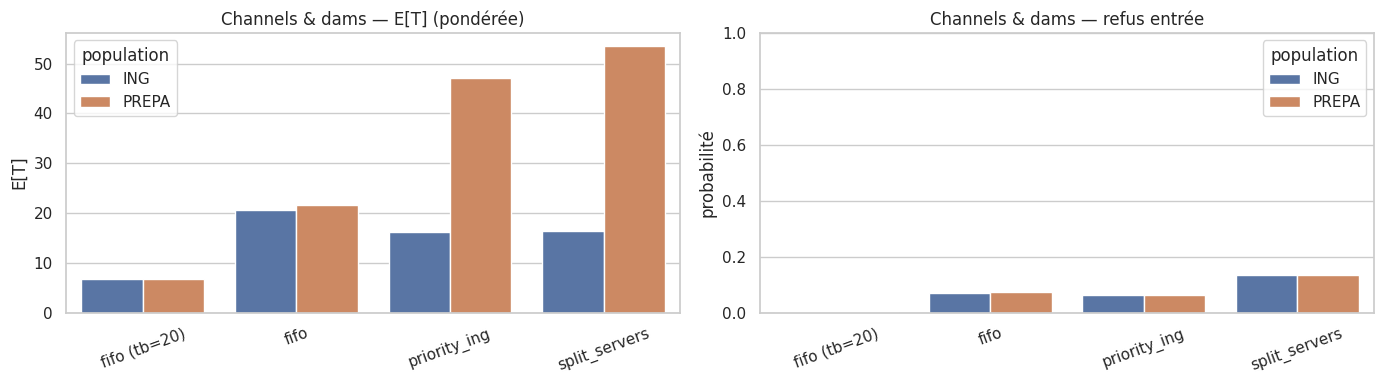

In [18]:
# Plot: E[T] par politique et population
plot_df = cd_summary.copy()
plot_df['policy_label'] = plot_df.apply(
    lambda r: f"{r['policy']} (tb={int(r['dam_tb'])})" if np.isfinite(r['dam_tb']) else str(r['policy']),
    axis=1,
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.barplot(
    data=plot_df,
    x='policy_label', y='mean_sojourn_weighted', hue='population',
    ax=axes[0]
)
axes[0].set_title('Channels & dams — E[T] (pondérée)')
axes[0].set_xlabel('')
axes[0].set_ylabel('E[T]')
axes[0].tick_params(axis='x', rotation=20)

rate_df = plot_df.copy()
rate_df['refused_stage1_rate'] = rate_df['refused_stage1_rate'].clip(0, 1)
sns.barplot(
    data=rate_df,
    x='policy_label', y='refused_stage1_rate', hue='population',
    ax=axes[1]
)
axes[1].set_ylim(0, 1)
axes[1].set_title('Channels & dams — refus entrée')
axes[1].set_xlabel('')
axes[1].set_ylabel('probabilité')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
save_fig(fig, 'channels_dams_policies')
plt.show()

## Conclusion — Channels & dams (politiques)
- La politique influence fortement l’équité : une priorité ING diminue la latence ING mais dégrade nettement PREPA (effet de famine possible).
- Le partage fixe des serveurs (`split_servers`) peut stabiliser la qualité de service PREPA mais augmente les refus si un groupe se retrouve sous-dimensionné.
- Le barrage périodique (ici `fifo (tb=20)`) lisse l’arrivée ING : il réduit la congestion globale et améliore simultanément la latence et les pertes, au prix d’un délai supplémentaire pour ING pendant les phases fermées.

In [19]:
# Sweep tb pour visualiser le compromis (ING) : refus vs E[T]
tb_values = [5.0, 10.0, 20.0, 40.0]
rows = []
for tb in tb_values:
    for sd in seeds3:
        metrics_by_pop, _ = simulate_channels_and_dams(
            seed=int(sd), horizon=float(H3),
            exec_servers=int(K3), send_service_rate=float(mu_f3),
            ks=int(ks3), kf=int(kf3), populations=pops,
            dam_tb=float(tb), dam_population='ING', policy='fifo',
        )
        m = metrics_by_pop['ING']
        rows.append({
            'tb': tb, 'seed': sd,
            **m.to_dict(),
        })

tb_runs = pd.DataFrame(rows)
tb_summary = summarize_runs(tb_runs, group_cols=['tb'])
tb_summary

,tb,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,5.0,48016,16029,0,4,4,4,16002,0.000000,0.000250,0.000250,4.291380
1,10.0,47877,15847,0,12,12,12,15755,0.000000,0.000757,0.000757,5.160675
2,20.0,47920,15669,8,28,28,28,15636,0.000167,0.001787,0.001787,6.677923
3,40.0,48696,15841,50,794,794,794,15017,0.001027,0.050123,0.050123,10.286861


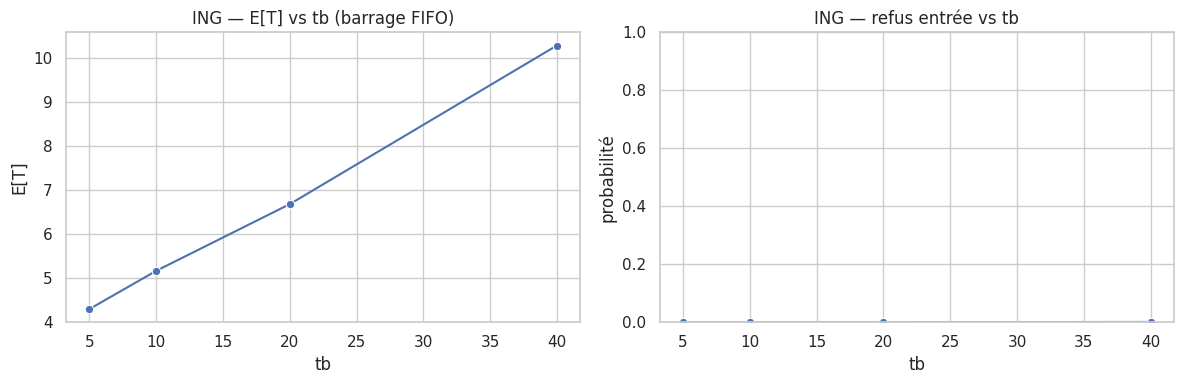

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data=tb_summary, x='tb', y='mean_sojourn_weighted', marker='o', ax=ax[0])
ax[0].set_title('ING — E[T] vs tb (barrage FIFO)')
ax[0].set_ylabel('E[T]')

sns.lineplot(data=tb_summary, x='tb', y='refused_stage1_rate', marker='o', ax=ax[1])
ax[1].set_title('ING — refus entrée vs tb')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('probabilité')

plt.tight_layout()
save_fig(fig, 'channels_dams_tb_sweep_ING')
plt.show()

## Conclusion — Effet de `tb` (barrage FIFO, population ING)
- Quand `tb` augmente, la latence $E[T]$ augmente : le barrage retient les jobs plus longtemps pendant les phases fermées.
- Dans cette configuration, le refus à l’entrée reste quasi nul pour les petits `tb`, puis des pertes apparaissent pour un `tb` très grand (ici 40), ce qui suggère une accumulation trop importante pendant les périodes fermées.
- Il existe donc un compromis : un barrage trop agressif dégrade la latence et finit par créer de la congestion au redémarrage.

In [21]:
# Export (optionnel)
cd_runs.to_csv(RESULTS_DIR / 'channels_dams_runs.csv', index=False)
cd_summary.to_csv(RESULTS_DIR / 'channels_dams_summary.csv', index=False)
tb_runs.to_csv(RESULTS_DIR / 'tb_sweep_runs_ING.csv', index=False)
tb_summary.to_csv(RESULTS_DIR / 'tb_sweep_summary_ING.csv', index=False)

export_table(cd_summary, 'channels_dams_summary', index=False)
export_table(tb_summary, 'channels_dams_tb_summary_ING', index=False)

RESULTS_DIR

PosixPath('results')

## Benchmarks multi-paramètres — Channels & dams
On évalue l’impact de la politique, du nombre de serveurs, du barrage, des vitesses et des coûts sur toutes les métriques clés :
- Temps de séjour moyen
- Taux de refus à l’entrée
- Taux de pages blanches
- Nombre moyen de jobs en file/système
- Coût total et coût par arrivée

In [22]:
# Sweep multi-paramètres Channels & dams : politique, K, mu_f, ks, kf, tb
H_mp_cd = 600.0
seeds_mp_cd = list(range(1, 8))
K_mp_cd = [2, 3, 4]
mu_f_mp_cd = [1.0, 2.0]
ks_mp_cd = [10, 30]
kf_mp_cd = [5, 30]
tb_mp_cd = [None, 10.0, 30.0]
policies_mp_cd = ['fifo', 'priority_ing', 'split_servers']
pop_names = ['ING', 'PREPA']

rows = []
for K in K_mp_cd:
    for mu_f in mu_f_mp_cd:
        for ks_ in ks_mp_cd:
            for kf_ in kf_mp_cd:
                for tb in tb_mp_cd:
                    for policy in policies_mp_cd:
                        for sd in seeds_mp_cd:
                            pops = [
                                Population(name='ING', arrival_rate=3.0, exec_service_rate=1.5),
                                Population(name='PREPA', arrival_rate=0.6, exec_service_rate=0.5)
                            ]
                            split = {'ING': K-1, 'PREPA': 1} if policy == 'split_servers' else None
                            metrics_by_pop, _jobs = simulate_channels_and_dams(
                                seed=int(sd), horizon=float(H_mp_cd),
                                exec_servers=int(K), send_service_rate=float(mu_f),
                                ks=int(ks_), kf=int(kf_),
                                populations=pops,
                                dam_tb=tb, dam_population='ING',
                                policy=policy, split_servers_for=split,
                            )
                            for pop_name in pop_names:
                                m = metrics_by_pop[pop_name]
                                rows.append({
                                    'seed': sd, 'K': K, 'mu_f': mu_f, 'ks': ks_, 'kf': kf_,
                                    'tb': tb if tb is not None else np.nan, 'policy': policy, 'population': pop_name,
                                    **m.to_dict(),
                                })
mp_cd_runs = pd.DataFrame(rows)
mp_cd_summary = summarize_runs(mp_cd_runs, group_cols=['K', 'mu_f', 'ks', 'kf', 'tb', 'policy', 'population'])
export_table(mp_cd_summary, 'channels_dams_multi_param_summary', index=False)
mp_cd_summary.head(10)

,K,mu_f,ks,kf,tb,policy,population,arrivals,accepted,refused_stage1,stage2_refused,blank_pages,permanent_blanks,completed,refused_stage1_rate,blank_pages_rate_given_accepted,permanent_blank_rate_given_accepted,mean_sojourn_weighted
0,2,1.0,10,5,10.0,fifo,ING,12753,3582,602,1445,1445,1445,2065,0.047205,0.403406,0.403406,7.685601
1,2,1.0,10,5,10.0,fifo,PREPA,2461,2280,181,529,529,529,1722,0.073547,0.232018,0.232018,8.037763
2,2,1.0,10,5,10.0,priority_ing,ING,12647,3673,506,1540,1540,1540,2065,0.040009,0.419276,0.419276,6.255132
3,2,1.0,10,5,10.0,priority_ing,PREPA,2497,2358,139,545,545,545,1787,0.055667,0.231128,0.231128,9.799412
4,2,1.0,10,5,10.0,split_servers,ING,12654,2763,1516,787,787,787,1934,0.119804,0.284835,0.284835,6.168597
5,2,1.0,10,5,10.0,split_servers,PREPA,2574,2055,519,385,385,385,1609,0.201632,0.187348,0.187348,18.860172
6,2,1.0,10,5,30.0,fifo,ING,12662,2916,1203,1325,1325,1325,1591,0.095009,0.454390,0.454390,8.553022
7,2,1.0,10,5,30.0,fifo,PREPA,2612,2339,273,384,384,384,1906,0.104518,0.164173,0.164173,7.443768
8,2,1.0,10,5,30.0,priority_ing,ING,12704,3260,901,1706,1706,1706,1554,0.070923,0.523313,0.523313,6.786485
9,2,1.0,10,5,30.0,priority_ing,PREPA,2622,2423,199,397,397,397,1970,0.075896,0.163846,0.163846,9.457901


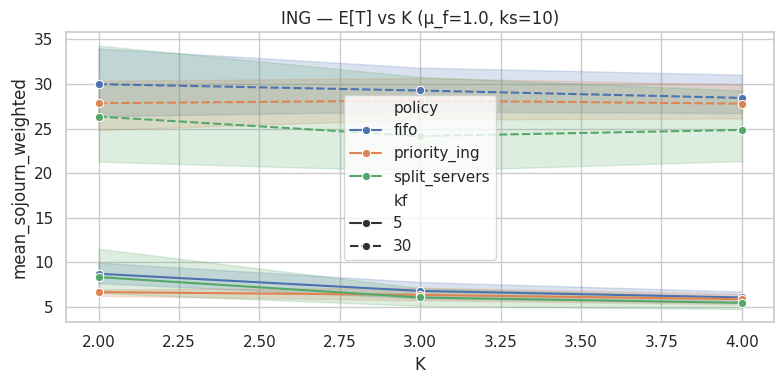

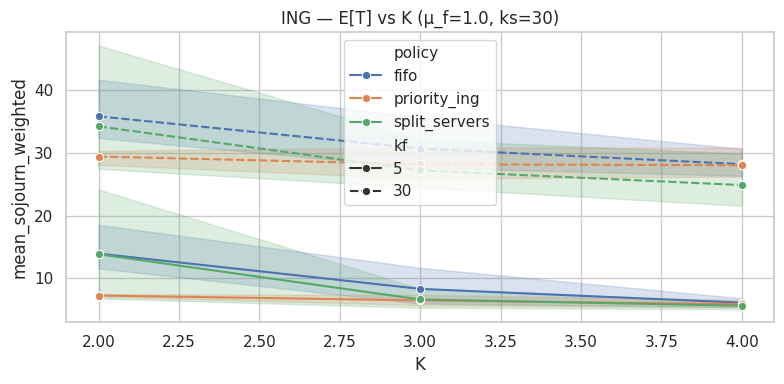

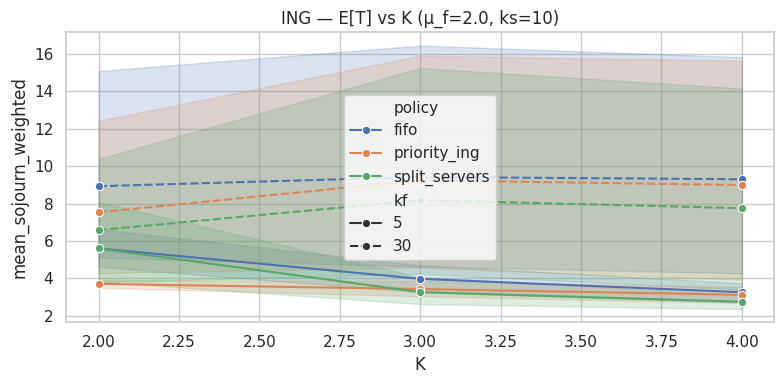

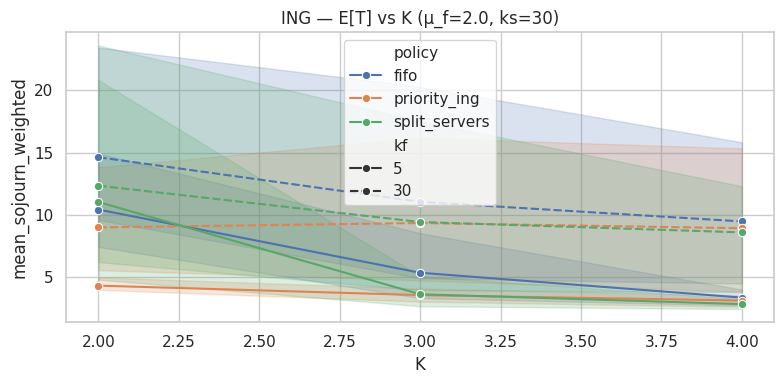

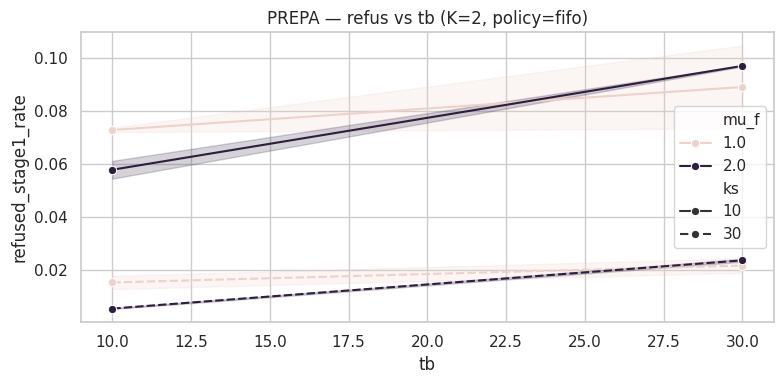

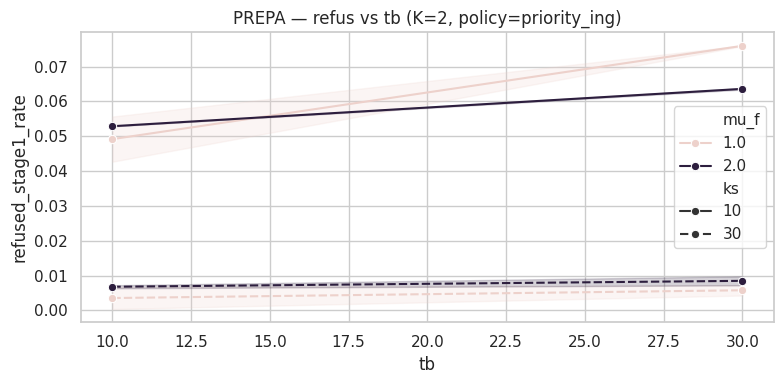

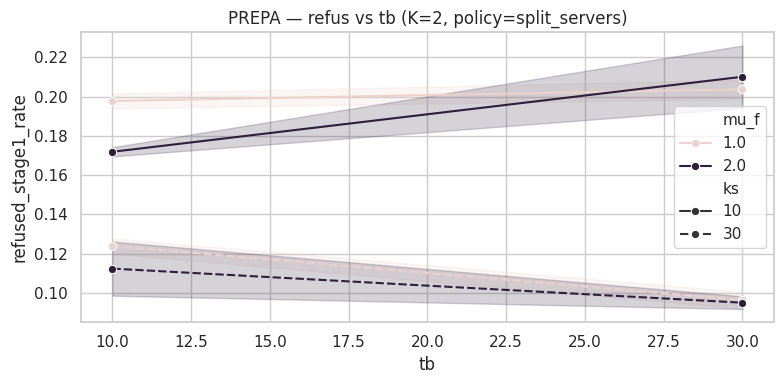

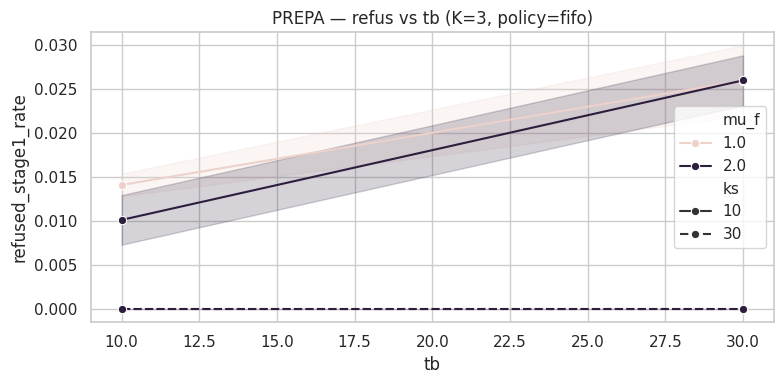

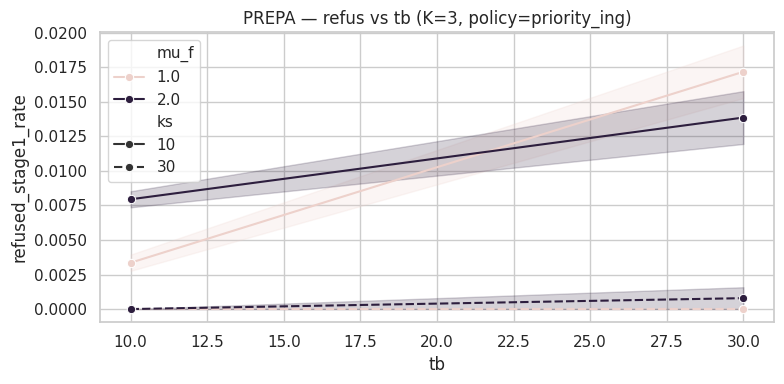

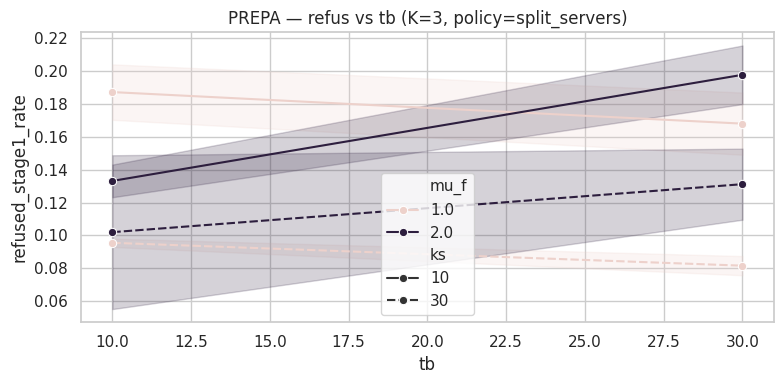

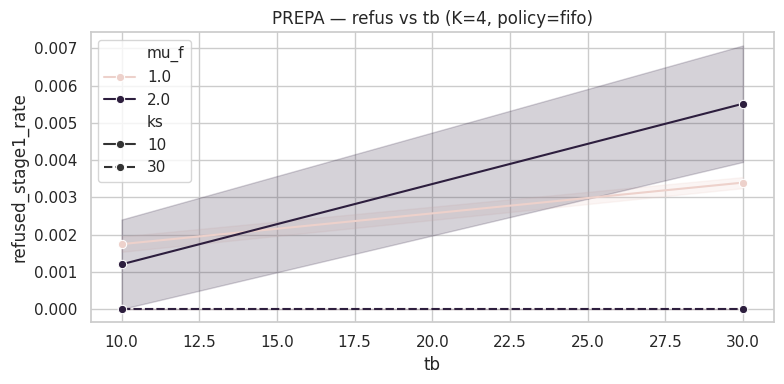

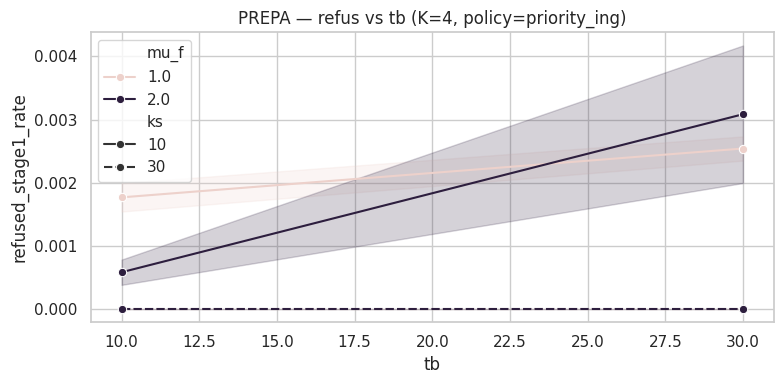

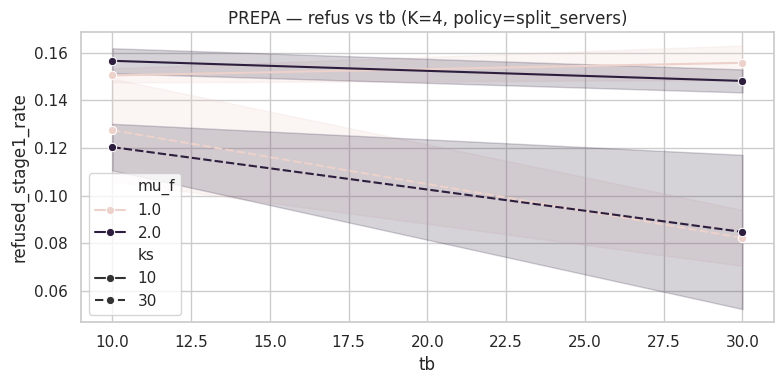

In [23]:
# Visualisation : impact des paramètres Channels & dams

def plot_cd_param_impact(df, param, metric, hue=None, style=None, title=None, fname=None):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(data=df, x=param, y=metric, hue=hue, style=style, marker='o', ax=ax)
    ax.set_title(title or f'{metric} vs {param}')
    ax.set_ylabel(metric)
    plt.tight_layout()
    if fname:
        save_fig(fig, fname)
    plt.show()

# Exemple : impact du nombre de serveurs et de la politique sur E[T] pour ING
for mu_f in mu_f_mp_cd:
    for ks_ in ks_mp_cd:
        sub = mp_cd_summary[(mp_cd_summary['mu_f'] == mu_f) & (mp_cd_summary['ks'] == ks_) & (mp_cd_summary['population'] == 'ING')]
        plot_cd_param_impact(sub, param='K', metric='mean_sojourn_weighted', hue='policy', style='kf',
                            title=f'ING — E[T] vs K (μ_f={mu_f}, ks={ks_})',
                            fname=f'cd_ING_ET_K_mu_f{mu_f}_ks{ks_}')

# Impact du barrage tb sur le refus pour PREPA
for K in K_mp_cd:
    for policy in policies_mp_cd:
        sub = mp_cd_summary[(mp_cd_summary['K'] == K) & (mp_cd_summary['policy'] == policy) & (mp_cd_summary['population'] == 'PREPA')]
        plot_cd_param_impact(sub, param='tb', metric='refused_stage1_rate', hue='mu_f', style='ks',
                            title=f'PREPA — refus vs tb (K={K}, policy={policy})',
                            fname=f'cd_PREPA_refus_tb_K{K}_policy{policy}')

### Conclusions sur l'impact des paramètres (Channels & dams)

- **Nombre de serveurs (K)** : Augmenter K réduit le temps de séjour et le taux de refus pour ING et PREPA, mais l’effet dépend de la politique et du partage.
- **μ_f (vitesse de sortie)** : Plus μ_f est élevé, plus le système évacue vite les jobs, ce qui réduit la congestion et les refus.
- **ks/kf (capacités)** : Des buffers plus grands (ks, kf) réduisent les refus, surtout pour PREPA si la politique favorise ING.
- **tb (barrage)** : Un barrage bien dimensionné lisse la charge ING, réduit la congestion et améliore la qualité pour PREPA, mais peut augmenter la latence ING.
- **Politique** : La priorité ING ou le split des serveurs modifient l’équité et la performance pour chaque population.

**Synthèse** :
- Pour optimiser la qualité de service et le coût, il faut ajuster K, μ_f, ks/kf, tb et la politique selon les besoins de chaque population.
- Les visualisations ci-dessus permettent d’identifier les compromis entre latence, refus et équité pour ING et PREPA.

In [24]:
# Export des résultats multi-paramètres Channels & dams
mp_cd_runs.to_csv(RESULTS_DIR / 'channels_dams_multi_param_runs.csv', index=False)
mp_cd_summary.to_csv(RESULTS_DIR / 'channels_dams_multi_param_summary.csv', index=False)
export_table(mp_cd_summary, 'channels_dams_multi_param_summary', index=False)
RESULTS_DIR

PosixPath('results')